# Аннотация изображений

Аннотировать изображения будем в формате ограничивающих рамок (bounding boxes) в формате, пригодном для обучения нейросетей на базе фреймворка **Pytorch** (т.е. для весов `.pt` и классов `.yaml`).

В качестве основного инструмента аннотирования предлагается использовать автоматическую аннотацию на базе большой и тяжелой нейронной сети **Grounding DINO**. 

Несмотря на то, что такой подход обладает очевидными недостатками в виде больших погрешностей построения ограничивающих рамок и ограниченными возможностями самих аннотаций, все же аннотирование большого датасета (~ 1000 изображений) займет большое количество времени, которое можно было бы потратить на разработку.

## Перед началом...

Нам необходимо убедиться, что на компьютере есть видеокарта. В целом, можно обучить и на ЦП (яблочный M2 очень даже неплох), но на видеокарте все равно быстрее.

In [2]:
import subprocess

try:
    subprocess.check_output('nvidia-smi')
    print('Nvidia GPU detected')
    !nvidia-smi
except Exception:
    print('No Nvidia GPU in system')

Nvidia GPU detected
Mon Jul  8 20:26:14 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 552.44                 Driver Version: 552.44         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060 Ti   WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   41C    P8             22W /  220W |    1046MiB /   8192MiB |     35%      Default |
|                                         |                        |                  N/A |
+---------------------------

## Устанавливаем зависимости

Нам нужна библиотека autodistill (для аннотирования), roboflow (для обучения) и supervision (для графики).

**ВАЖНО:** Autodistill это библиотека, использующая большие, медленные модели для обучения маленьких и быстрых. Каждую модель можно найти на GitHub и/или загрузить через пакетный менджер `pip`.

In [3]:
!pip install -q autodistill autodistill-grounded-sam autodistill-yolov8 roboflow supervision==0.9.0


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


**ВАЖНО:** Для того, чтобы было проще взаимодействовать с данными, изображениями и моделями объявим переменную `HOME`.

In [4]:
import os
HOME = os.getcwd()
print(HOME)

Z:\dev\ITT_practicum\data_processing


## Подготовка датасета

**ВАЖНО:** Для того, чтобы использовать библиотеку Autodistill нам необходимо создать папку с изображениями, которые мы хотим аннотировать и использовать для обучения целевой нейросети.

In [5]:
IMAGE_DIR_PATH = f"{HOME}/../images"

In [6]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('Image count:', len(image_paths))

Image count: 154


**ВАЖНО:** Можно вывести парочку изображений из нашего датасета.

In [7]:
IMAGE_DIR_PATH = f"{HOME}/../images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

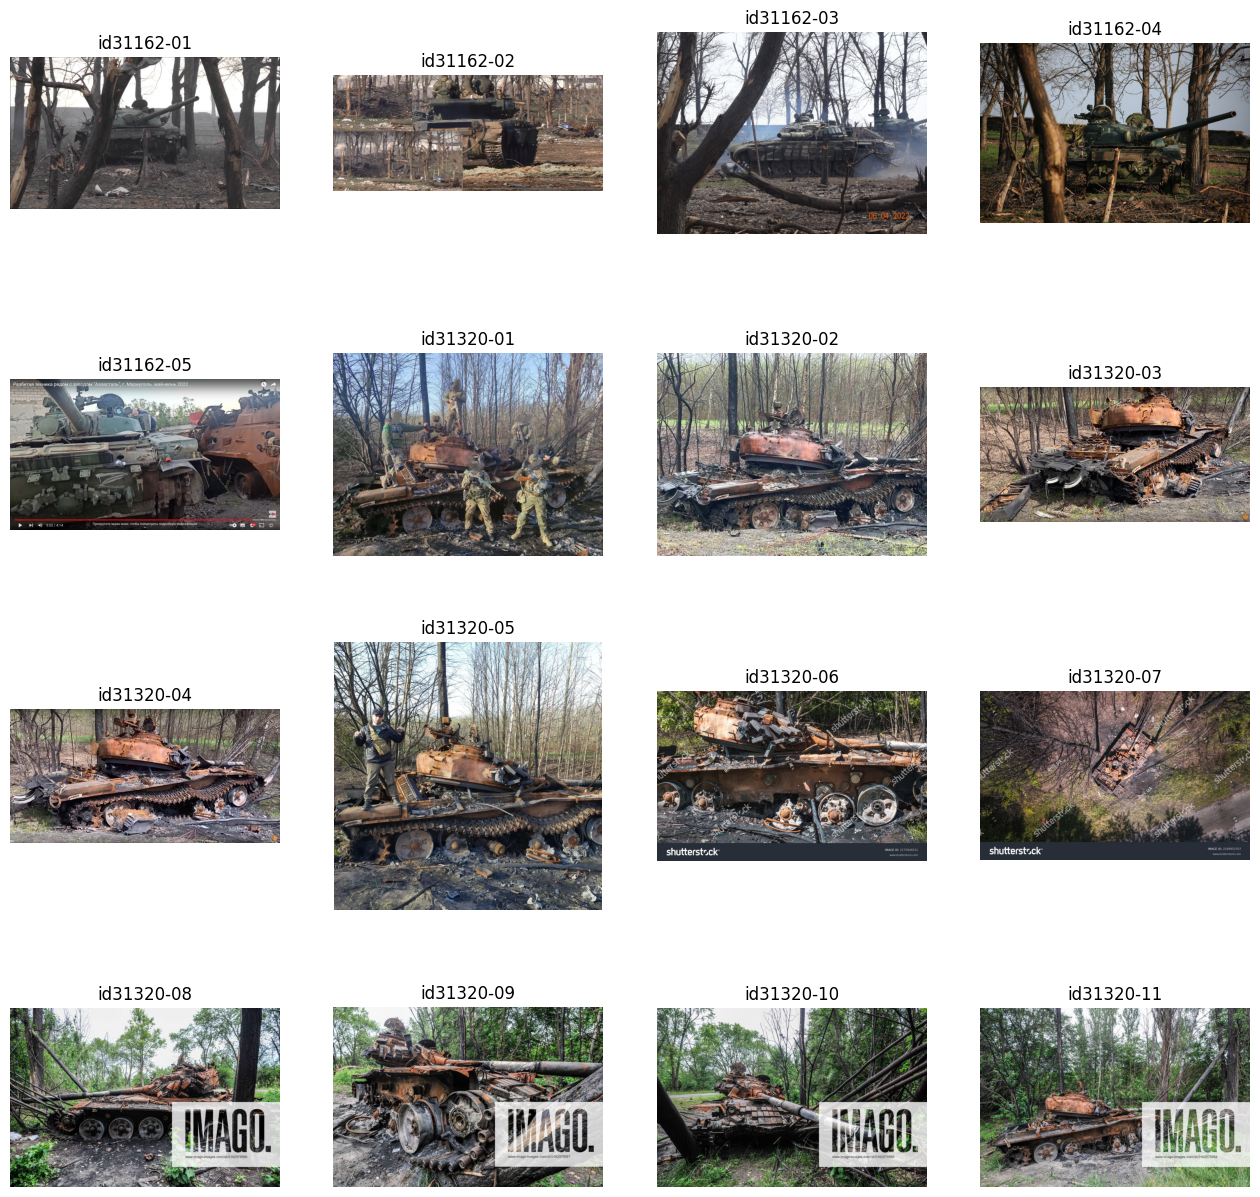

In [8]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

## Автоматическая аннотация

### Определение онтологии

**Онтология** определяет запросы, отправляемые к базовой модели, т.е. что содержит наш датасет и на чем мы будем его обучать. Простой пример онтологии можно воспроизвести с помощью класса `CaptionOntology`, который отправляет базовой модели запросы в формате словаря (ключ - значение), где ключ - это описание класса, а значение - название класса. 

In [9]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "tank": "tank"
})

### Определение базовой модели и автоматическая аннотация

Базовая модель - это большая фундаментальная модель, которая знает все обо всем. Базовые модели зачастую мультимодальные, т.е. могут выполнять множество задач. Они крупные, медленные и очень дорогие в обучении. Пример таких моделей: GroubdedSAM и GPT-4. Мы будем использовать базовую модель (вместе с не аннотированными данными и онтологией) для того, чтобы создать полноценный датасет.

In [10]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**ВАЖНО:** Базовые модели очень медленные... Можно принести себе чай, так как обучение займет некоторое время.

Проверяем, есть ли у нас CUDA. Если нет, то обучение пройдет гораздо медленнее.

In [11]:
import torch
torch.cuda.is_available()

True

In [13]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".jpg",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased
downloading dino model weights
final text_encoder_type: bert-base-uncased
*******************************************
<_io.BufferedReader name='C:\\Users\\y2kbimbo/.cache/autodistill\\groundingdino\\groundingdino_swint_ogc.pth'>
*******************************************
*******************************************
<_io.BufferedReader name='C:\\Users\\y2kbimbo/.cache/autodistill\\segment_anything\\sam_vit_h_4b8939.pth'>
*******************************************


Labeling Z:\dev\ITT_practicum\data_processing/../images\id31162-01.jpg:   0%|          | 0/77 [00:00<?, ?it/s]The `device` argument is deprecated and will be removed in v5 of Transformers.
1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:455.)
torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
None of the inputs have requires_grad=True. Gradients will be None
Labeling Z:\dev\ITT_practicum\data_processing/../images\id46031-03.jpg: 100%|██████████| 77/77 [01:58<00:00,  1.54s/it]


Labeled dataset created - ready for distillation.


### Показываем часть аннотированных данных

In [17]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [18]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

print('Final dataset images count:', len(dataset))

Final dataset images count: 61


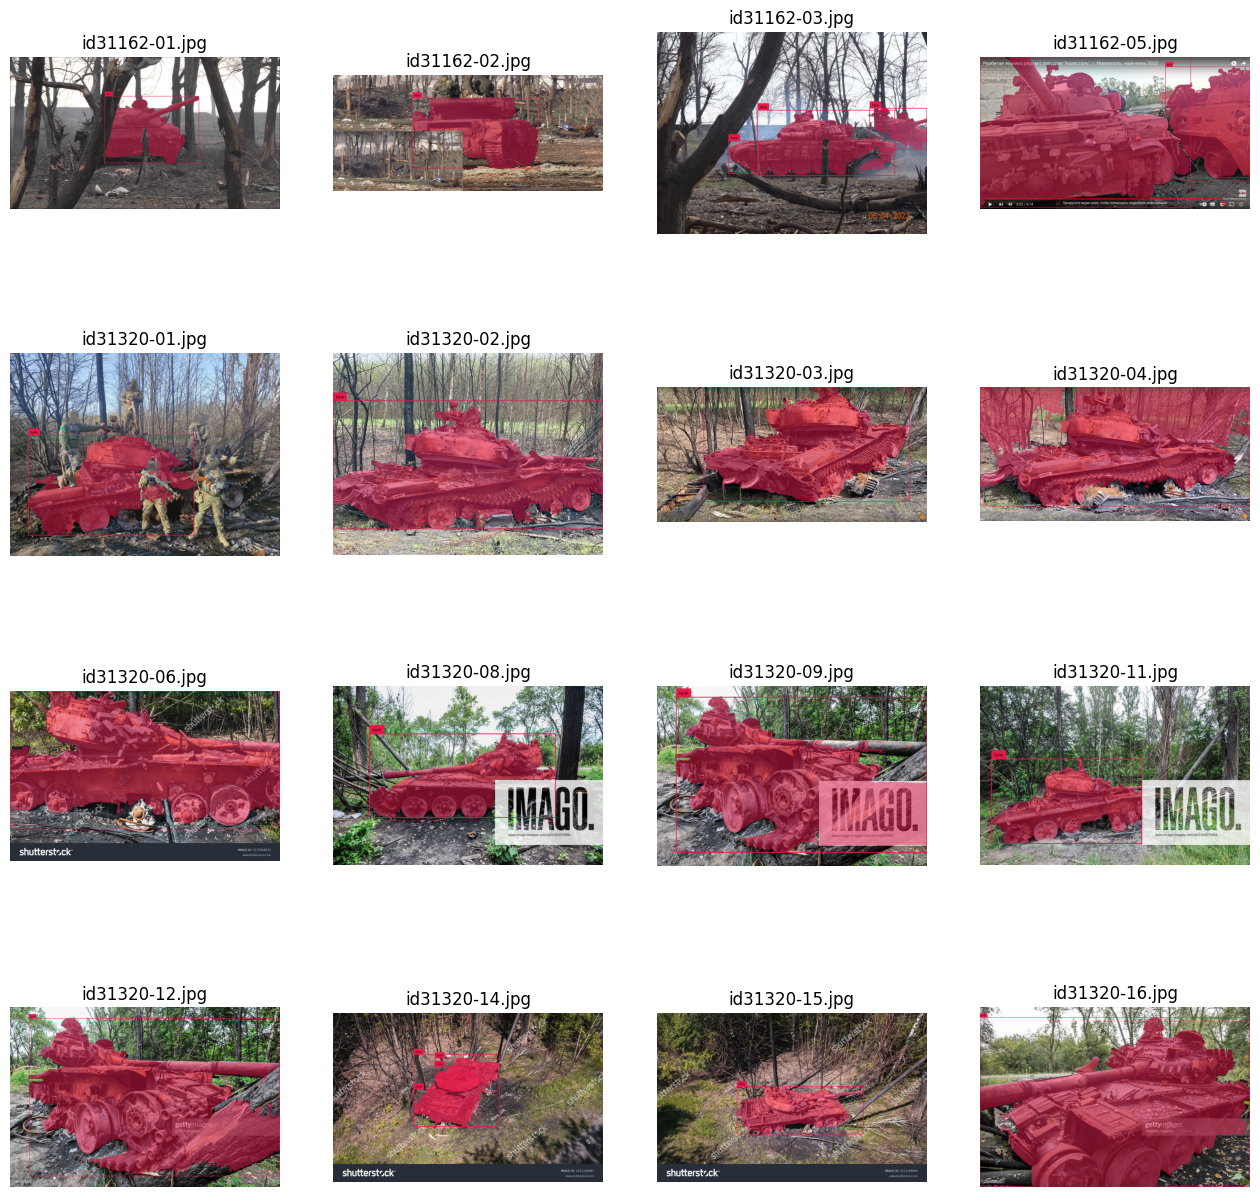

In [16]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)